In [5]:
import pandas as pd
import numpy as np
import re
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve
from itertools import izip
from sklearn.cross_validation import cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.svm import SVC
% matplotlib inline

## Load the table

In [6]:
batters = pd.read_csv('/home/jun/Galvanize/capstone/Galvanize_capstone/Data/Players/batters.csv')

In [7]:
batters = batters.drop('Unnamed: 0', axis=1)

## Let's play with the batters data

In [8]:
batters.dtypes[batters.dtypes == object]

Aff_batting          object
Fielding_position    object
Height               object
Lev                  object
Lg_batting           object
Name                 object
Tm                   object
dtype: object

### Height

In [9]:
batters.Height.unique()

array(['6\' 1"', '6\' 4"', '6\' 3"', '6\' 2"', '5\' 11"', '6\' 0"',
       '5\' 9"', nan, '5\' 10"', '6\' 6"', '5\' 7"', '5\' 8"', '6\' 5"',
       '6\' 7"', '5\' 5"', '6\' 8"', '5\' 6"', '5\' 3"', '6\' 9"',
       '5\' 1"', '5\' 0"'], dtype=object)

In [10]:
def convert_to_meters(height):
    try:
        h = re.findall(r'\d', height)
        return (int(h[0]) * 12 * 2.54) + (int(h[1]) * 2.54)
    except TypeError:
        pass

In [11]:
convert_to_meters(batters.Height[5])

193.04

In [12]:
batters.Height = batters.Height.apply(lambda x: convert_to_meters(x))

In [13]:
batters.Height = batters.Height.fillna(batters.Height.mean())  # filling the rest with its mean

### Dropping column 'Fielding_position'

In [17]:
batters = batters.drop('Fielding_position', axis=1)

In [18]:
batters.columns

Index([u'2B', u'3B', u'A', u'AB', u'Aff_batting', u'AgeDif_batting',
       u'Age_batting', u'BA', u'BB_batting', u'Bats_Right', u'Bats_both',
       u'Bats_left', u'Bats_unknown', u'CS_batting', u'CS_fielding',
       u'CS_perc', u'Catcher', u'Centerfielder', u'Ch', u'DP', u'Designated',
       u'Drafted', u'E', u'First', u'Fld_perc', u'G', u'GDP', u'G_batting',
       u'HBP_batting', u'HR_batting', u'H_batting', u'Height', u'Hitter',
       u'IBB_batting', u'Leftfielder', u'Lev', u'Lg_batting', u'N/A', u'Name',
       u'OBP', u'OPS', u'Outfielder', u'PA', u'Pitcher', u'RBI', u'RF/G',
       u'R_batting', u'Rightfielder', u'Rookie?', u'SB_batting',
       u'SB_fielding', u'SF', u'SH', u'SLG', u'SO_batting', u'Second',
       u'Shortstop', u'TB', u'Third', u'Throws_left', u'Throws_right',
       u'Throws_unknown', u'Tm', u'Weight', u'Year', u'player_id'],
      dtype='object')

### Column 'A' (Assists - defensive stat)

In [19]:
batters['A'] = batters['A'].fillna(batters['A'].mean())  # filling NaN with mean value

In [20]:
batters[batters['A'].isnull()]  # checking

,2B,3B,A,AB,Aff_batting,AgeDif_batting,Age_batting,BA,BB_batting,Bats_Right,...,Shortstop,TB,Third,Throws_left,Throws_right,Throws_unknown,Tm,Weight,Year,player_id


-----

### Dropping few rows and columns

In [21]:
batters = batters.drop('N/A', axis=1) # dropping 'N/A' column, which means the position is N/A

In [22]:
batters.columns

Index([u'2B', u'3B', u'A', u'AB', u'Aff_batting', u'AgeDif_batting',
       u'Age_batting', u'BA', u'BB_batting', u'Bats_Right', u'Bats_both',
       u'Bats_left', u'Bats_unknown', u'CS_batting', u'CS_fielding',
       u'CS_perc', u'Catcher', u'Centerfielder', u'Ch', u'DP', u'Designated',
       u'Drafted', u'E', u'First', u'Fld_perc', u'G', u'GDP', u'G_batting',
       u'HBP_batting', u'HR_batting', u'H_batting', u'Height', u'Hitter',
       u'IBB_batting', u'Leftfielder', u'Lev', u'Lg_batting', u'Name', u'OBP',
       u'OPS', u'Outfielder', u'PA', u'Pitcher', u'RBI', u'RF/G', u'R_batting',
       u'Rightfielder', u'Rookie?', u'SB_batting', u'SB_fielding', u'SF',
       u'SH', u'SLG', u'SO_batting', u'Second', u'Shortstop', u'TB', u'Third',
       u'Throws_left', u'Throws_right', u'Throws_unknown', u'Tm', u'Weight',
       u'Year', u'player_id'],
      dtype='object')

In [84]:
batters = batters[batters['Bats_unknown'] == 0]  # Dropping rows of players whose 'Bats_unknown' column is 'Yes'

In [85]:
batters = batters.drop(['Bats_unknown', 'Pitcher', 'Hitter', 'Throws_right', 'Throws_left',
                        'Throws_unknown', 'H_batting', 'E', 'SB_fielding'
                       ], axis=1 )

In [86]:
batters = batters[batters['AB'] != 0]  # filtering out 'batters' with zero AB

### Converting CS_batting (CS = Cut-stealing) into percentage

In [87]:
batters['CS_perc_batting'] = batters['CS_batting'] / (batters['CS_batting'] + batters['SB_batting'])

In [88]:
batters = batters.drop('CS_batting', axis=1)

In [89]:
batters = batters.drop('CS_fielding', axis=1)

In [90]:
batters = batters.rename(columns = {'CS_perc': 'CS_perc_fielding'})

### Creating a new column for Unintentional Base on Balls by BB - IBB(Intentional BB)

In [95]:
batters['uBB_batting'] = batters['BB_batting'] - batters['IBB_batting']

In [96]:
batters = batters.drop('BB_batting', axis=1)

## Converting stats as average per AB (At-bats) or total number of AB + other on-base stats such as HBP (Hit by pitch) and SF (Sacrifice fly) that do not count in AB

In [97]:
batters[['SB_batting', 'SF', 'SH', 'TB']] =\
    batters[['SB_batting', 'SF', 'SH', 'TB']].apply(
        lambda x: x / (batters['AB'] + (batters[[
                        'HBP_batting', 'uBB_batting', 'IBB_batting', 'SF', 'SH']].sum(axis=1))))

In [98]:
batters[['2B', '3B', 'HR_batting', 'R_batting', 'RBI', 'GDP', 'SO_batting']] = \
    batters[['2B', '3B', 'HR_batting', 'R_batting', 'RBI', 'GDP', 'SO_batting']].apply(
        lambda x: x / (batters['AB'] + 1))  
# for AB; dividing everything by AB + 1; adding 1 to prevent division by 0

### Converting the rest as average per games

In [99]:
batters[['Ch', 'DP', 'A']] = batters[['Ch', 'DP', 'A']].apply(lambda x: x / (batters['G'] + 1))

------

In [100]:
batters.loc[batters.uBB_batting == batters.uBB_batting.max()]

,2B,3B,A,AB,Aff_batting,AgeDif_batting,Age_batting,BA,Bats_Right,Bats_both,...,Second,Shortstop,TB,Third,Tm,Weight,Year,player_id,CS_perc_batting,uBB_batting
26639,0.000118,0.0,0.000694,441.0,SDP,0.2,27.0,0.293,0.0,0.0,...,0.0,0.0,0.409475,0.0,Portland,250.0,2006,7915,1.0,143.0


In [101]:
batters.shape

(123536, 55)

In [102]:
batters['Rookie?'].value_counts()

0    122232
1      1304
Name: Rookie?, dtype: int64

# Dropping league levels other than FRk, Rk, A-, A, Ind, A+, AA, AAA

In [104]:
batters.Lev.value_counts() # Is it safe to drop?

AAA    20443
Rk     18157
A+     15414
AA     15050
A      14128
Ind    11946
A-      9273
FRk     7647
FgW     6337
Fgn     2470
MLB     1265
Fal     1210
WRk      196
Name: Lev, dtype: int64

In [105]:
Lv_kept = ['FRk', 'Rk', 'A-', 'A', 'Ind', 'A+', 'AA', 'AAA']
Lv_drop = ['WRk', 'MLB', 'FgW', 'Fal', 'Fgn'] 

In [106]:
batters.index = range(batters.shape[0]) # resetting the index by order

In [107]:
Lv_kept_dict = {}
for ix, lv in enumerate(Lv_kept):
    Lv_kept_dict[lv] = ix

In [108]:
test = batters.copy() # saving a copy

In [109]:
idx_tbd = []
for idx, elem in enumerate(test.Lev):
    if elem in Lv_drop:
        idx_tbd.append(idx)
    else:
        test.set_value(idx, 'Lev', Lv_kept_dict[elem])

In [110]:
test = test.drop(test.index[idx_tbd])

In [111]:
test.shape

(112058, 55)

---

### Testing by keeping only the last row of the duplicated ones, and add a new col 'Prev_lev'

In [238]:
duplicated_rows = test[test.duplicated(['player_id', 'Year'], keep=False)][['player_id', 'Year', 'Lev', 'AB', 'G']]

In [239]:
prev_idx_set = duplicated_rows.groupby(['player_id', 'Year']).groups  # idx for each duplicated set

In [240]:
test.insert(1, 'Pre_lev', test.Lev)

In [241]:
for values in prev_idx_set.values():
    test = test.set_value(values[-1], 'Pre_lev', test.ix[values[-2]].Lev)

In [242]:
test = test.drop_duplicates(['player_id', 'Year'], keep='last')

In [243]:
test[['Lev', 'Pre_lev']] = test[['Lev', 'Pre_lev']].apply(lambda x: pd.to_numeric(x))

In [112]:
test = test[test.A.notnull()]

In [113]:
test.Weight = test.Weight.fillna(test.Weight.mean())

In [114]:
test.CS_perc_batting = test.CS_perc_batting.fillna(-1)

In [118]:
test = test.drop(['Bats_both', 'Designated'], axis=1)

In [120]:
test.Drafted = test.Drafted.apply(lambda x: 100 if x==0 else x)

In [124]:
test = test.drop(['2B', '3B', 'A', 'DP', 'G', 'HBP_batting', 'IBB_batting', 'SF', 'SH', 'uBB_batting'], axis=1)

In [125]:
test.to_csv('X_batting.csv')

In [115]:
test.shape

(110681, 55)

----

In [257]:
test.ix[123129]['player_id']

37628.0

In [127]:
X = test.copy()

In [128]:
y = X.pop('Rookie?')

In [129]:
X = X.loc[:, X.dtypes!=object]

In [130]:
X = X.drop(['player_id', 'Year'], axis=1)

In [134]:
y.value_counts()

0    109631
1      1050
Name: Rookie?, dtype: int64

In [147]:
labels = test['Rookie?'].apply(lambda x: 'Yes' if x == 1 else 'No')

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [136]:
model_RF = RandomForestClassifier()
model_GB = GradientBoostingClassifier()
model_AB = AdaBoostClassifier()

In [137]:
model_RF.fit(X_train, y_train)
model_GB.fit(X_train, y_train)
model_AB.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [138]:
print model_RF.score(X_test, y_test)
print model_GB.score(X_test, y_test)
print model_AB.score(X_test, y_test)

0.989953380796
0.989483574862
0.98988110296


In [139]:
y_RF = model_RF.predict(X_test)
y_GB = model_GB.predict(X_test)
y_AB = model_AB.predict(X_test)

In [140]:
print precision_score(y_test, y_RF)
print precision_score(y_test, y_GB)
print precision_score(y_test, y_AB)

0.8
0.0833333333333
1.0


In [141]:
print recall_score(y_test, y_RF)
print recall_score(y_test, y_GB)
print recall_score(y_test, y_AB)

0.0142348754448
0.00355871886121
0.00355871886121


In [142]:
print roc_auc_score(y_test, y_RF)
print roc_auc_score(y_test, y_GB)
print roc_auc_score(y_test, y_AB)

0.507099182885
0.501578556218
0.501779359431


In [143]:
confusion_matrix(y_test, y_RF)

array([[27389,     1],
       [  277,     4]])

In [144]:
confusion_matrix(y_test, y_GB)

array([[27379,    11],
       [  280,     1]])

In [145]:
confusion_matrix(y_test, y_AB)

array([[27390,     0],
       [  280,     1]])

In [743]:
y_RF_p = model_RF.predict_proba(X_test)
y_GB_p = model_GB.predict_proba(X_test)
y_AB_p = model_AB.predict_proba(X_test)

In [758]:
y_test[y_test == 1].index

Int64Index([ 84339,  67595, 119683,  62615,  90634,  74336,  93740,  86395,
             85426,  94163,
            ...
            109529,  36713,  75094,  81684,  90220, 109133,  61563, 105723,
            117355,  68347],
           dtype='int64', length=167)

In [79]:
y.value_counts()

0    84463
1      706
Name: Rookie?, dtype: int64

In [80]:
1 / (706./(84463+706))

120.63597733711048

In [130]:
sample_weight = np.array([120 if i == 1 else 1 for i in y_train])

In [149]:
model_RF = RandomForestClassifier(n_estimators=50, n_jobs=4, class_weight='balanced')

In [150]:
model_RF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [151]:
model_RF.score(X_test, y_test)

0.99154651763490353

In [787]:
scores = cross_val_score(model_RF, X_train, y_train, fit_params={'sample_weight': sample_weight}, cv=10, scoring='accuracy', n_jobs=4)

In [788]:
scores

array([ 0.99154665,  0.99154665,  0.99154665,  0.99154665,  0.99139011,
        0.99154665,  0.99139011,  0.99154533,  0.99154533,  0.9917006 ])

In [152]:
y_pred = model_RF.predict(X_test)

In [153]:
precision_score(y_test, y_pred)

0.0

In [154]:
recall_score(y_test, y_pred)

0.0

In [156]:
confusion_matrix(y_test, y_pred)

array([[21113,     0],
       [  180,     0]])

In [155]:
y_test.value_counts()

0    21113
1      180
Name: Rookie?, dtype: int64

## Trying some under-sampling...

In [255]:
RandomUnderSampler??

In [289]:
rus = RandomUnderSampler(0.1)
X_resampled, y_resampled = rus.fit_sample(X_train, y_train)

In [290]:
model_RF = RandomForestClassifier(n_estimators=100, n_jobs=4)

In [291]:
model_RF.fit(X_resampled, y_resampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [292]:
model_RF.score(X_test, y_test)

0.98940998487140697

In [293]:
y_pred = model_RF.predict(X_test)

In [294]:
print precision_score(y_test, y_pred)
print recall_score(y_test, y_pred)

0.135802469136
0.0666666666667


In [295]:
roc_auc_score(y_test, y_pred)

0.53166563428153935

In [272]:
roc_curve(y_test, y_pred)

(array([ 0.        ,  0.22666413,  1.        ]),
 array([ 0.        ,  0.73333333,  1.        ]),
 array([2, 1, 0]))

In [273]:
confusion_matrix(y_test, y_pred)

array([[16230,  4757],
       [   44,   121]])

In [296]:
y_proba = model_RF.predict_proba(X_test)

In [303]:
y_proba

array([[ 0.99,  0.01],
       [ 0.93,  0.07],
       [ 0.78,  0.22],
       ..., 
       [ 0.66,  0.34],
       [ 0.87,  0.13],
       [ 0.93,  0.07]])

In [307]:
y_proba[1][y_test == 0]

/home/jun/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  if __name__ == '__main__':


array([ 0.07,  0.07,  0.07, ...,  0.07,  0.07,  0.07])

In [274]:
y_test.value_counts()

0    20987
1      165
Name: Rookie?, dtype: int64

In [275]:
importances = model_RF.feature_importances_

In [276]:
indices = np.argsort(importances)[::-1]

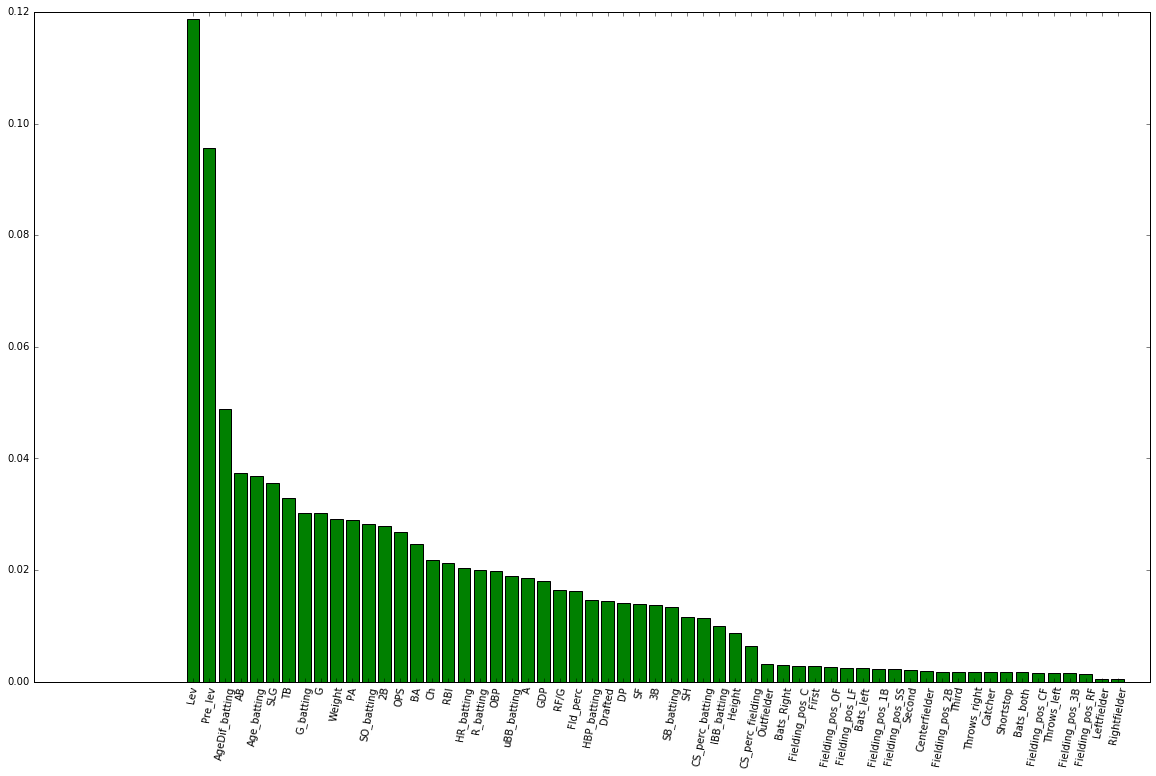

In [277]:
plt.figure(figsize=(20,12))
_ = plt.bar(range(X_train.shape[1]), importances[indices], align='center', label = X_train.columns[indices], color='green')
_ = plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=80)

In [183]:
136 / 167.

0.8143712574850299

### How about over-sampling with SMOTE?

In [278]:
sm = SMOTE(kind='regular')
X_resampled, y_resampled = sm.fit_sample(X_train, y_train)

In [279]:
model_RF = RandomForestClassifier(n_estimators=100, n_jobs=4)
model_RF.fit(X_resampled, y_resampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [280]:
model_RF.score(X_test, y_test)

0.99205748865355525

In [281]:
y_pred = model_RF.predict(X_test)

In [282]:
print precision_score(y_test, y_pred)
print recall_score(y_test, y_pred)

0.285714285714
0.0121212121212


In [283]:
roc_auc_score(y_test, y_pred)

0.50594148469976363

In [284]:
y_proba = model_RF.predict_proba(X_test)

In [285]:
y_proba[1][y_test == 1]

/home/jun/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  if __name__ == '__main__':


array([ 1.,  1.,  1., ...,  1.,  1.,  1.])

In [286]:
importances = model_RF.feature_importances_

In [287]:
indices = np.argsort(importances)[::-1]

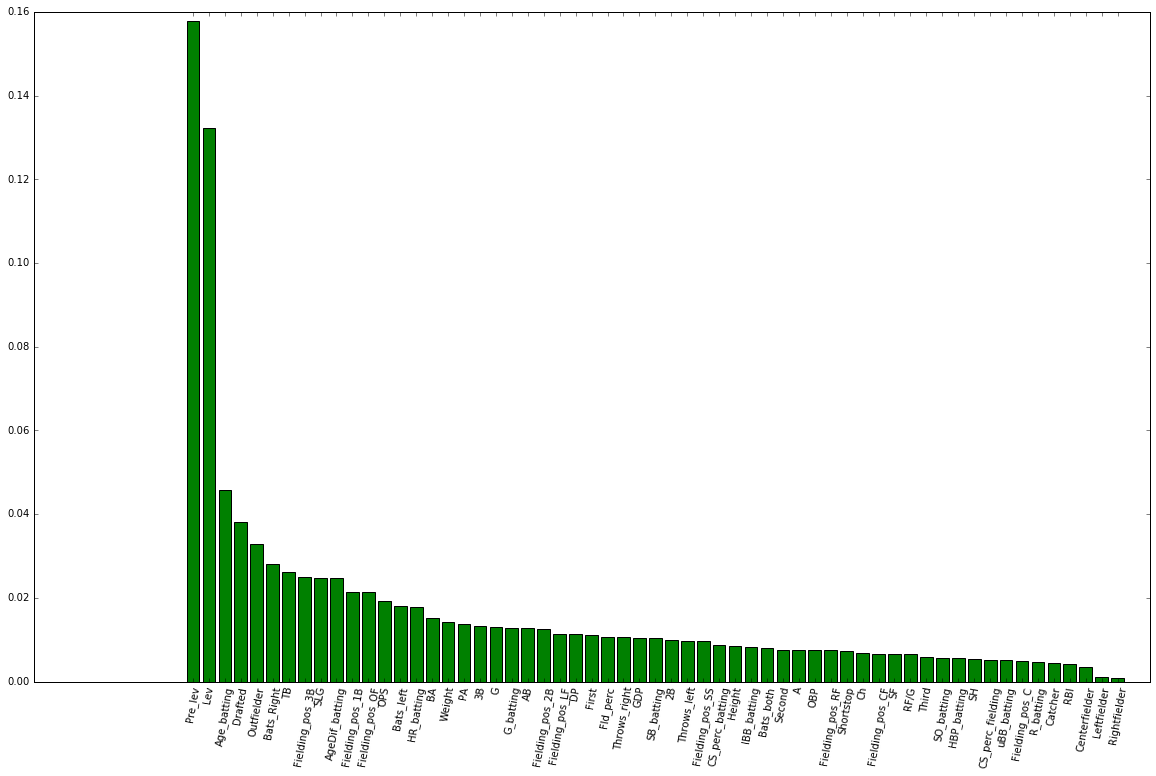

In [288]:
plt.figure(figsize=(20,12))
_ = plt.bar(range(X_train.shape[1]), importances[indices], align='center', label = X_train.columns[indices], color='green')
_ = plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=80)

In [112]:
columns = X_test.columns

In [98]:
confusion_matrix(y_test, y_pred)

array([[21117,     7],
       [  166,     3]])

In [210]:
X_train[y_train == 1].describe().T

,count,mean,std,min,25%,50%,75%,max
2B,526.0,0.054879,0.024904,0.00,0.042039,0.054110,0.067623,0.187500
Pre_lev,526.0,7.123574,2.166836,0.00,6.000000,7.000000,8.750000,10.000000
Lev,526.0,7.112167,2.734047,0.00,6.000000,7.000000,10.000000,10.000000
3B,526.0,0.007114,0.008397,0.00,0.000000,0.004808,0.011462,0.061224
A,526.0,0.954263,1.008982,0.00,0.093842,0.553173,1.876926,4.041667
AB,526.0,238.893536,173.138810,1.00,87.000000,191.000000,411.000000,596.000000
AgeDif_batting,526.0,-1.615589,2.261787,-8.30,-3.000000,-1.500000,-0.200000,6.200000
Age_batting,526.0,23.321293,2.501315,17.00,22.000000,23.000000,25.000000,35.000000
BA,526.0,0.273970,0.059026,0.00,0.250000,0.278000,0.304000,0.565000
Bats_Right,526.0,0.574144,0.494943,0.00,0.000000,1.000000,1.000000,1.000000


In [209]:
X_train[y_train == 0].describe()

,2B,Pre_lev,Lev,3B,A,AB,AgeDif_batting,Age_batting,BA,Bats_Right,...,Fielding_pos_CF,Fielding_pos_DH,Fielding_pos_LF,Fielding_pos_N/A,Fielding_pos_OF,Fielding_pos_RF,Fielding_pos_SS,Fielding_pos_Unknown,uBB_batting,CS_perc_batting
count,63350.000000,63350.000000,63350.000000,63350.000000,63350.000000,63350.000000,63350.000000,63350.000000,63350.000000,63350.000000,...,63350.000000,63350.000000,63350.000000,63350.000000,63350.000000,63350.000000,63350.000000,63350.000000,63350.000000,63350.000000
mean,0.045385,4.649803,4.823978,0.006711,0.912029,174.049329,-0.192418,23.180852,0.245835,0.616085,...,0.114870,0.000268,0.172549,0.000110,0.234680,0.147482,0.200505,0.000600,0.085195,0.081153
std,0.030067,3.227262,3.301352,0.011686,0.973365,139.675862,2.688684,4.121716,0.077757,0.486341,...,0.318867,0.016379,0.377860,0.010511,0.423802,0.354589,0.400382,0.024485,0.049638,0.627266
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-14.300000,14.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,0.028226,1.000000,2.000000,0.000000,0.088889,57.000000,-1.600000,20.000000,0.212000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055002,0.000000
50%,0.045455,5.000000,5.000000,0.002625,0.541667,141.000000,-0.300000,22.000000,0.251000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.081395,0.250000
75%,0.060976,7.000000,7.000000,0.010101,1.666667,260.000000,1.100000,25.000000,0.286000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.500000
max,0.571429,10.000000,10.000000,0.500000,27.800000,603.000000,26.700000,53.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.800000,1.000000
